Machine Learning aplicado a la predicción de precio de criptomonedas, utilizando valores anteriores de las principales critpomonedas, valores de índices de stocks, y trends de búsqueda. 

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

#Manejo de archivos
import os
import tempfile
import shutil
import json

import DataManager as dm

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


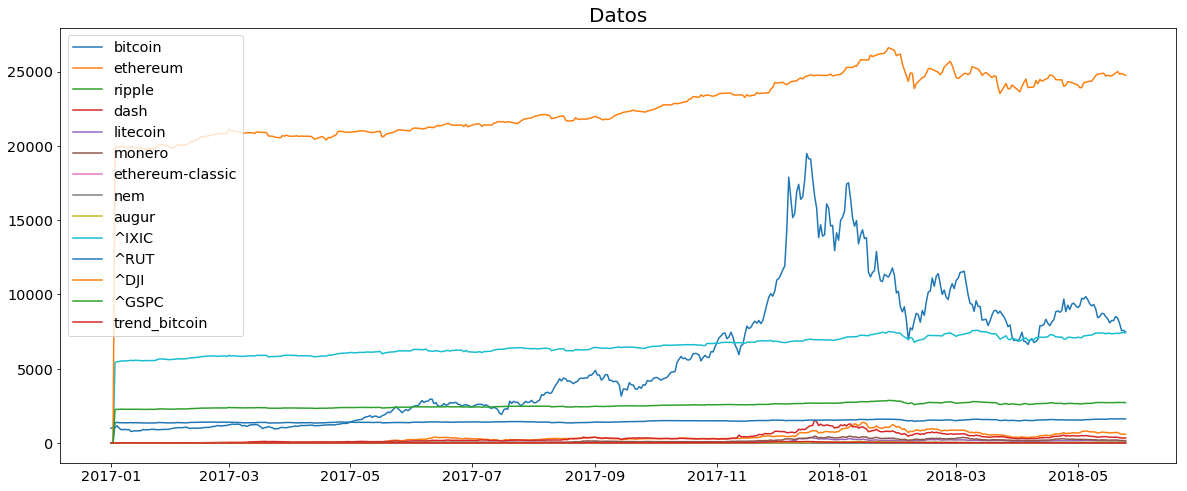

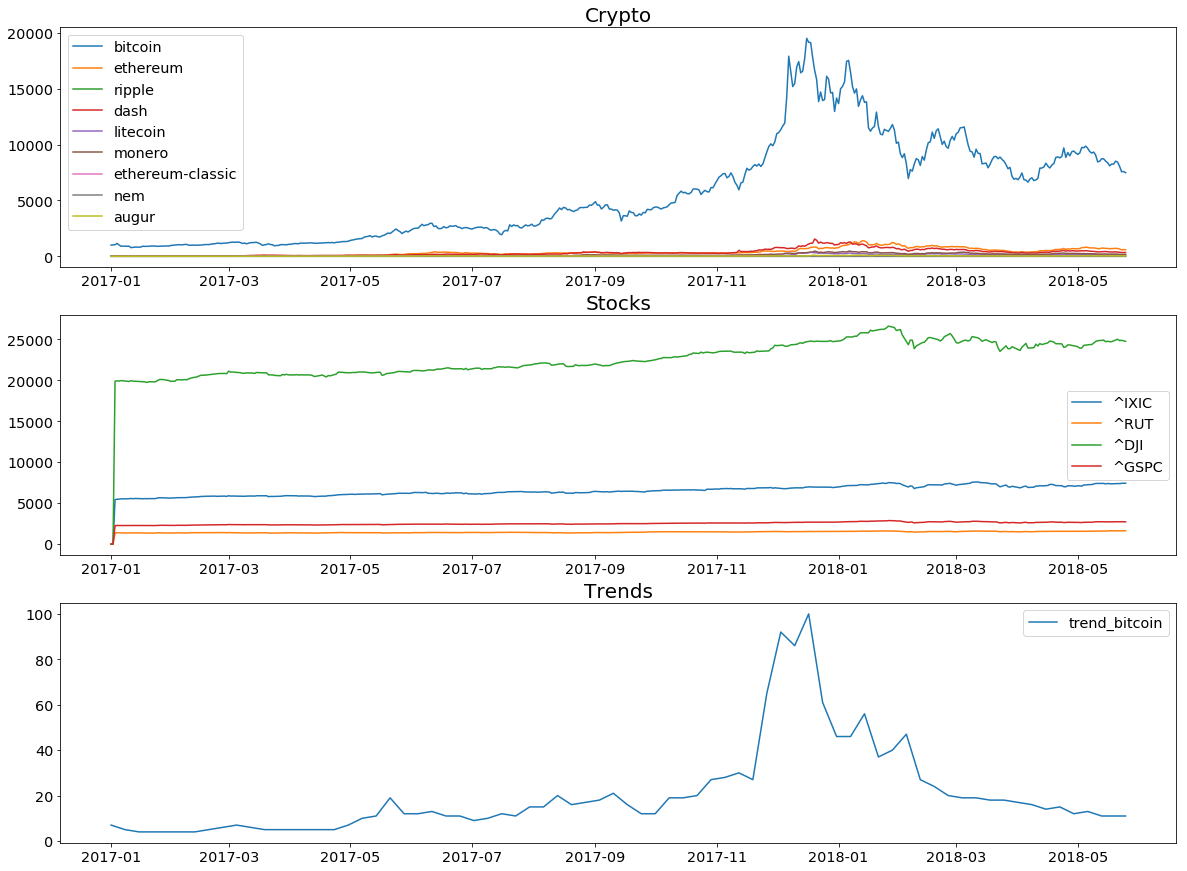

In [2]:
criptomonedas_posibles = ['bitcoin','ethereum','ripple','dash','litecoin',
                     'monero','ethereum-classic','nem','augur',                 
                     'litecoin','cardano','stellar','iota','tron',
                     'neo','dash','bitcoin-cash','eos','vechain',
                     'tether','qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

targets_crypto = top_criptomonedas
targets_stocks = ['^IXIC','^RUT','^DJI','^GSPC']
targets_trends = ['trend_bitcoin']

actualizar = False
if actualizar:
    crypto = dm.get_crypto(targets_crypto,fecha_comienzo='2017-01-01',fecha_fin='2018-05-25')
    stocks = dm.get_stocks(targets_stocks)
    trends = dm.get_trends(targets_trends,fecha_comienzo='2017-01-01',fecha_fin='2018-05-25')
    data = pd.merge(crypto, stocks,  how='left', left_index=True, right_index=True)
    data = pd.merge(data, trends,  how='left', left_index=True, right_index=True)
    data = data.interpolate().ffill().fillna(0) #Completar campos faltantes
    data.to_csv('data/data.csv')
else: 
    data = pd.read_csv('data/data.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

#Graficar la serie completa
plt.figure(figsize=(20,8))
for i in range(0,len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
plt.legend(loc='upper left')
plt.title("Datos",fontsize=20)
#plt.savefig('baselines/naive_seriecompleta.png')
plt.show()

#Graficar la serie completa
plt.figure(figsize=(20,15))
plt.subplot(3, 1, 1)
for i in range(0,len(targets_crypto)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Crypto",fontsize=20)
plt.subplot(3, 1, 2)
for i in range(len(targets_crypto),len(targets_crypto)+len(targets_stocks)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Stocks",fontsize=20)
plt.subplot(3, 1, 3)
for i in range(len(targets_crypto)+len(targets_stocks),len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Trends",fontsize=20)
#plt.savefig('baselines/naive_seriecompleta.png')
plt.show()

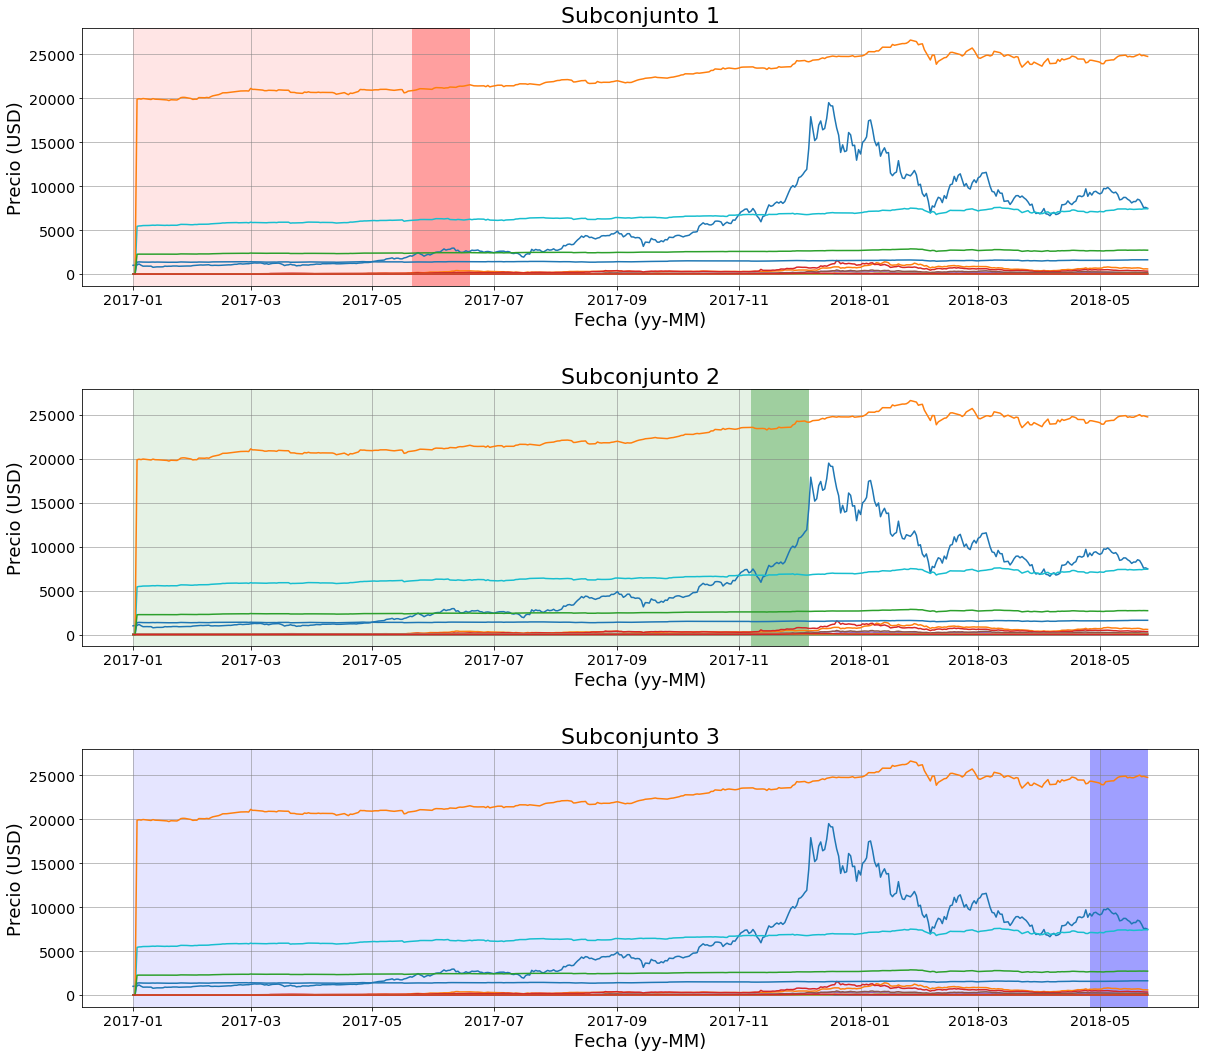

In [3]:
#Simulaciones
test_size = 30
ventana = [1,2,5,7]
neuronas = [2,4]
epochs = [30]
futuro = [1,2,5,7]
moneda = 'bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores = ['r','g','b']

conf_data = {
    'Moneda': 'bitcoin',
    'variables_crypto':targets_crypto,
    'variables_stocks':targets_stocks,
    'variables_trends':targets_trends,
    'N_tests': N_tests,
    'test_size':test_size,
    'futuro':futuro,
    'ventana':ventana,
    'neuronas':neuronas,
    'epochs':epochs
}

#Visualización de resultados
fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.4)
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    start_test = end-test_size
    subprediccion = data[0:end]
    subprediccion_test = data[start_test:end]    
    ax = plt.subplot(gs[n_test, 0:])
    ax.plot(data.index, data)  
    plt.axvspan(subprediccion.index[0], subprediccion.index[-1], facecolor=colores[n_test], alpha=0.1)
    plt.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores[n_test], alpha=0.3)
    plt.xlabel('Fecha (yy-MM)', fontsize=18)
    plt.ylabel('Precio (USD)', fontsize=18)
    #plt.legend(loc='upper left', labels=data.columns)
    plt.title("Subconjunto " + str(n_test+1),fontsize=22)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)

In [4]:
# Crear carpeta donde se almacenarán las predicciones        
if not os.path.exists("predicciones"):
    os.makedirs("predicciones") # Crear carpeta de predicciones
datasetfolder = "predicciones" + "/"  + moneda
if (os.path.exists(datasetfolder)):
    tmp = tempfile.mktemp(dir=os.path.dirname(datasetfolder))
    shutil.move(datasetfolder, tmp) # Mover el dir a una ubicacion temporal
    shutil.rmtree(tmp) # Eliminar la carpeta que existía
os.makedirs(datasetfolder)  

prediccioncompleta =  data[[moneda]].copy() # Todas las predicciones en un dataframe (output de la simulacion)
for f in futuro:
        for v in ventana:
            for n in neuronas:
                for e in epochs:    
                    dataset_name = 'f' + str(f) + 'v' + str(v) + 'n' + str(n) + 'e' + str(e)                   
                    prediccionxdataset = pd.DataFrame() # todos los subconjuntos de test en un dataframe
                    entrenamientos = []
                    for n_test in range(0,N_tests):
                        end = int((n_test+1)*len(data)/N_tests)
                        dataset = data.copy()[0:end]
                        
                        train = dataset[0:-test_size]
                        test_padding = f+v-1 # Lo que hay que agregarle al set test hacia atrás para ajustarse a 30 días de predicción
                        test = dataset[-test_size-test_padding:] 
                                                      
                        # Dividir el conjunto de training y testing en x,y
                        # La y se corre f-1 porque el generator del predictor asigna cada sample de x con un valor de y +1
                        # (es decir, que genera un target de un dia a futuro)
                        train_x = train[:len(train)-f+1] 
                        train_y = train[[moneda]][f-1:]                         
                        test_x  = test[:len(test)-f+1]
                        test_y  = test[[moneda]][f-1:]
                        prediccion_subset = dataset[[moneda]][-test_size:].copy() #Dataframe con una sola columma: el precio real (luego se añade la prediccion)
                        
                        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
                        scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
                        train_x_scaled = scalerX.transform(train_x)
                        test_x_scaled = scalerX.transform(test_x)
                        scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y.values.reshape(-1,1))
                        train_y_scaled = scalerY.transform(train_y.values.reshape(-1,1))
                        test_y_scaled = scalerY.transform(test_y.values.reshape(-1,1))
                        
                        '''TimeseriesGenerator crea una secuencia de samples, cada una de longitud *length*, 
                        tomadas de a *sampling_rate* timesteps. 
                        El end_index es la ultima posición que se va a tomar en los datos (tiene que ser +1 que la que se quiere)
                        El start_index es la primera posición desde la que se van a tomar los datos.
                        '''                        
                        validation_split = 0.8        
                        batch_s = 15
                        training_sequence = TimeseriesGenerator(train_x_scaled, train_y_scaled,
                                                   length=v, sampling_rate=1, 
                                                    end_index=int(len(train_x)*validation_split),
                                                   batch_size=batch_s)
                        validation_sequence = TimeseriesGenerator(train_x_scaled, train_y_scaled,
                                                           length=v, sampling_rate=1, 
                                                            start_index=int(len(train_x)*validation_split), end_index=len(train_x),
                                                           batch_size=batch_s)
                        testing_sequence = TimeseriesGenerator(test_x_scaled, test_y_scaled,
                                                          length=v, sampling_rate=1, 
                                                            end_index=len(test_x),
                                                           batch_size=1)

                        #Construir red neuronal y entrenarla
                        model = Sequential()
                        model.add(LSTM(units = n, dropout=0, 
                                           input_shape=(training_sequence[0][0].shape[1], #window_size
                                                        training_sequence[0][0].shape[2]))) #features
                        model.add(Dense(units = 1, activation = 'linear'))
                        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

                        history = model.fit_generator(training_sequence,
                                                                    validation_data=validation_sequence,
                                                                    epochs=e,verbose=0)  
                        
                        # Dataframe de entrenamiento
                        training_history = pd.DataFrame() 
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['val_loss'], columns=[dataset_name + '_val_loss'])], axis=1)
                        training_history.to_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv')
                        print('Entrenamiento ' + dataset_name + '('+ str(n_test+1) +') completo.')
                        entrenamientos.append(training_history)   
                              
                        #Predicción de testeo
                        predicted_scaled = model.predict_generator(testing_sequence)
                        predicted_scaled = predicted_scaled.reshape(-1,1)
                        predicted = scalerY.inverse_transform(predicted_scaled)
                                                     
                        # Dataframe de prediccion del subset  
                        prediccion_subset[dataset_name] = predicted
                        # Agregar la prediccion del subset (30 dias) al dataframe con la prediccion completa (3 tests)
                        prediccionxdataset = prediccionxdataset.append(prediccion_subset)
                        
                    print('Predicción ' + dataset_name + ' completa.')     
                    # Agregar la predicción completa (3 tests) al dataframe con TODAS las predicciones para la moneda
                    prediccioncompleta = pd.merge(prediccioncompleta,prediccionxdataset.drop(columns=[moneda]),how="left",left_index=True,right_index=True)

print("Simulación completa.")
print(prediccioncompleta)
prediccioncompleta.to_csv(datasetfolder + '/' + moneda +'.csv')

with open(datasetfolder + '/conf.json', 'w') as outfile:
    json.dump(conf_data, outfile)

Entrenamiento f1v1n2e30(1) completo.
Entrenamiento f1v1n2e30(2) completo.
Entrenamiento f1v1n2e30(3) completo.
Predicción f1v1n2e30 completa.
Entrenamiento f1v1n4e30(1) completo.
Entrenamiento f1v1n4e30(2) completo.
Entrenamiento f1v1n4e30(3) completo.
Predicción f1v1n4e30 completa.
Entrenamiento f1v2n2e30(1) completo.
Entrenamiento f1v2n2e30(2) completo.
Entrenamiento f1v2n2e30(3) completo.
Predicción f1v2n2e30 completa.
Entrenamiento f1v2n4e30(1) completo.
Entrenamiento f1v2n4e30(2) completo.
Entrenamiento f1v2n4e30(3) completo.
Predicción f1v2n4e30 completa.
Entrenamiento f1v5n2e30(1) completo.
Entrenamiento f1v5n2e30(2) completo.
Entrenamiento f1v5n2e30(3) completo.
Predicción f1v5n2e30 completa.
Entrenamiento f1v5n4e30(1) completo.
Entrenamiento f1v5n4e30(2) completo.
Entrenamiento f1v5n4e30(3) completo.
Predicción f1v5n4e30 completa.
Entrenamiento f1v7n2e30(1) completo.
Entrenamiento f1v7n2e30(2) completo.
Entrenamiento f1v7n2e30(3) completo.
Predicción f1v7n2e30 completa.
Entren